In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import nibabel as nib
from scipy.stats import pearsonr
import pandas as pd
from scipy.spatial.distance import squareform
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
from scipy.stats import kendalltau
import plotly.graph_objects as go


In [ ]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [ ]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

In [ ]:
from google.colab import drive
import numpy as np

drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/your_folder/'
chatbot_labels = np.load(folder_path + 'chatbot_labels.npy')
chatbot_labels_test = np.load(folder_path + 'chatbot_labels_test.npy')

print(chatbot_labels[:5])
print(chatbot_labels_test[:5])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['animate' 'inanimate' 'animate' 'animate' 'inanimate']
['inanimate' 'animate' 'animate' 'animate' 'inanimate']


In [ ]:
stimuli = dat['stimuli']
responses = dat['responses']
roi = dat['roi']
roi_names = dat['roi_names']
stimuli_test = dat['stimuli_test']
responses_test = dat['responses_test']
print(dat.keys())
X_train, X_test, y_train, y_test = stimuli, stimuli_test, responses, responses_test

roi_names = dat['roi_names']
roi_indices = dat['roi']
roi_responses = {}

for i, roi_name in enumerate(roi_names):
    roi_mask = (roi_indices == i)
    roi_responses[roi_name] = responses[:, roi_mask]

roi_responses_test = {}
for i, roi_name in enumerate(roi_names):
    roi_mask = (roi_indices == i)
    roi_responses_test[roi_name] = responses_test[:, roi_mask]



dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


In [ ]:
roi_responses.keys()

dict_keys(['Other', 'V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'])

In [ ]:
roi_responses['V1']

array([[ 0.81356815,  0.80712882, -1.04932228, ..., -1.13040574,
        -0.36799363, -1.57694956],
       [-0.89468871, -1.6246709 , -0.44189263, ...,  0.24612144,
        -0.73535669,  0.86854967],
       [-1.12824869, -0.07142458,  0.36138328, ...,  0.93161792,
         0.67164379,  0.76474526],
       ...,
       [-0.51093255,  1.55392352, -0.51422032, ...,  0.0504286 ,
        -0.72627915,  0.03931598],
       [-1.08626526, -1.14839827, -0.41331365, ...,  1.87400483,
         2.20840811,  2.22554281],
       [ 1.06931569,  0.44068302, -0.06721221, ...,  0.30182604,
         0.83582291,  0.46477002]])

In [ ]:
# Drop 'Other' from roi_responses
roi_responses.pop('Other', None)

array([], shape=(1750, 0), dtype=float64)

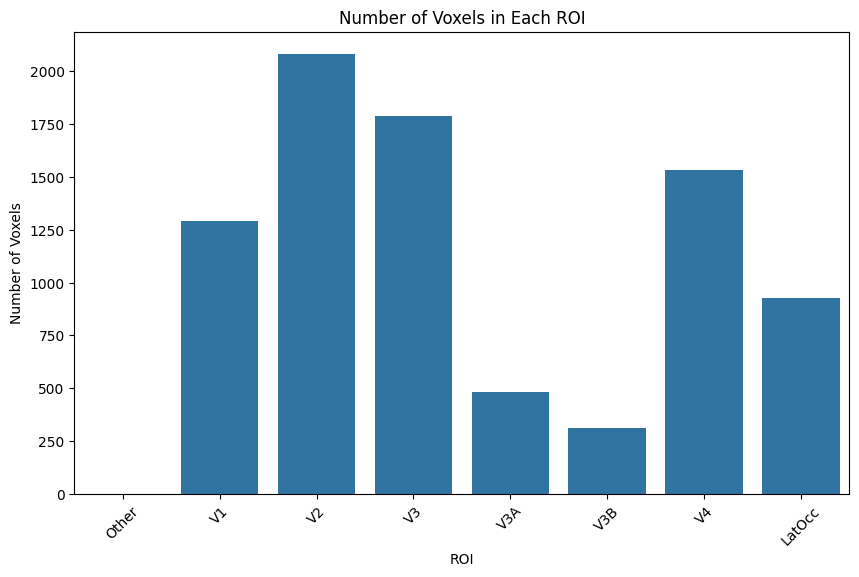

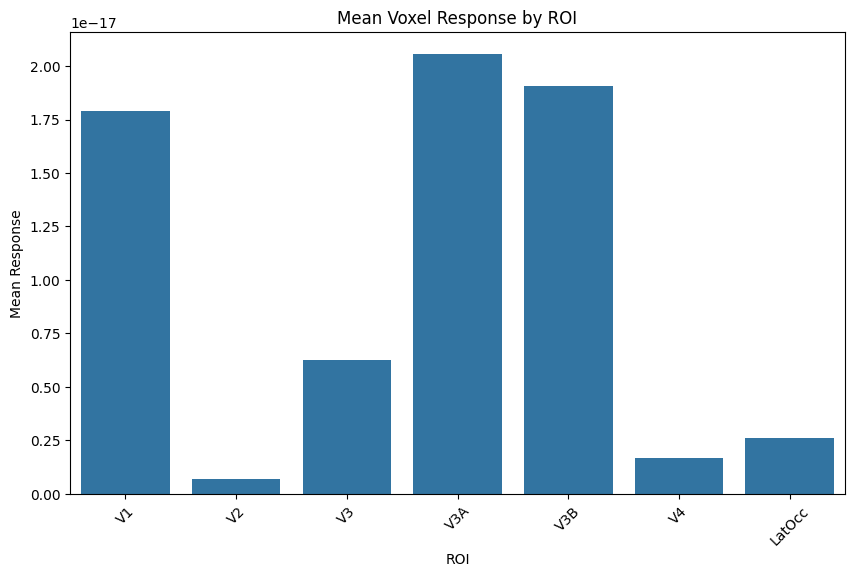

In [ ]:


roi_counts = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(roi_counts.keys()), y=list(roi_counts.values()))
plt.title("Number of Voxels in Each ROI")
plt.xlabel("ROI")
plt.ylabel("Number of Voxels")
plt.xticks(rotation=45)
plt.show()

def get_roi_indices(roi_name):
    return np.where(dat["roi_names"][dat["roi"]] == roi_name)[0]

roi_mean_responses = {roi: y_train[:, get_roi_indices(roi)].mean() for roi in roi_counts.keys() if roi != 'Other'}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(roi_mean_responses.keys()), y=list(roi_mean_responses.values()))
plt.title("Mean Voxel Response by ROI")
plt.xlabel("ROI")
plt.ylabel("Mean Response")
plt.xticks(rotation=45)
plt.show()

In [ ]:
chatbot_labels[:5]
unique_labels, label_counts = np.unique(chatbot_labels, return_counts=True)
categories = np.where(
    np.isin(chatbot_labels, ['face', 'people']) | (chatbot_labels == 'animate'),
    'animate',
    'inanimate'
)

np.unique(categories)
unique_categories, category_counts = np.unique(categories, return_counts=True)

print("--------------")

for category, count in zip(unique_categories, category_counts):
    print(f"{category}: {count}")

chatbot_labels=categories

--------------
animate: 877
inanimate: 873


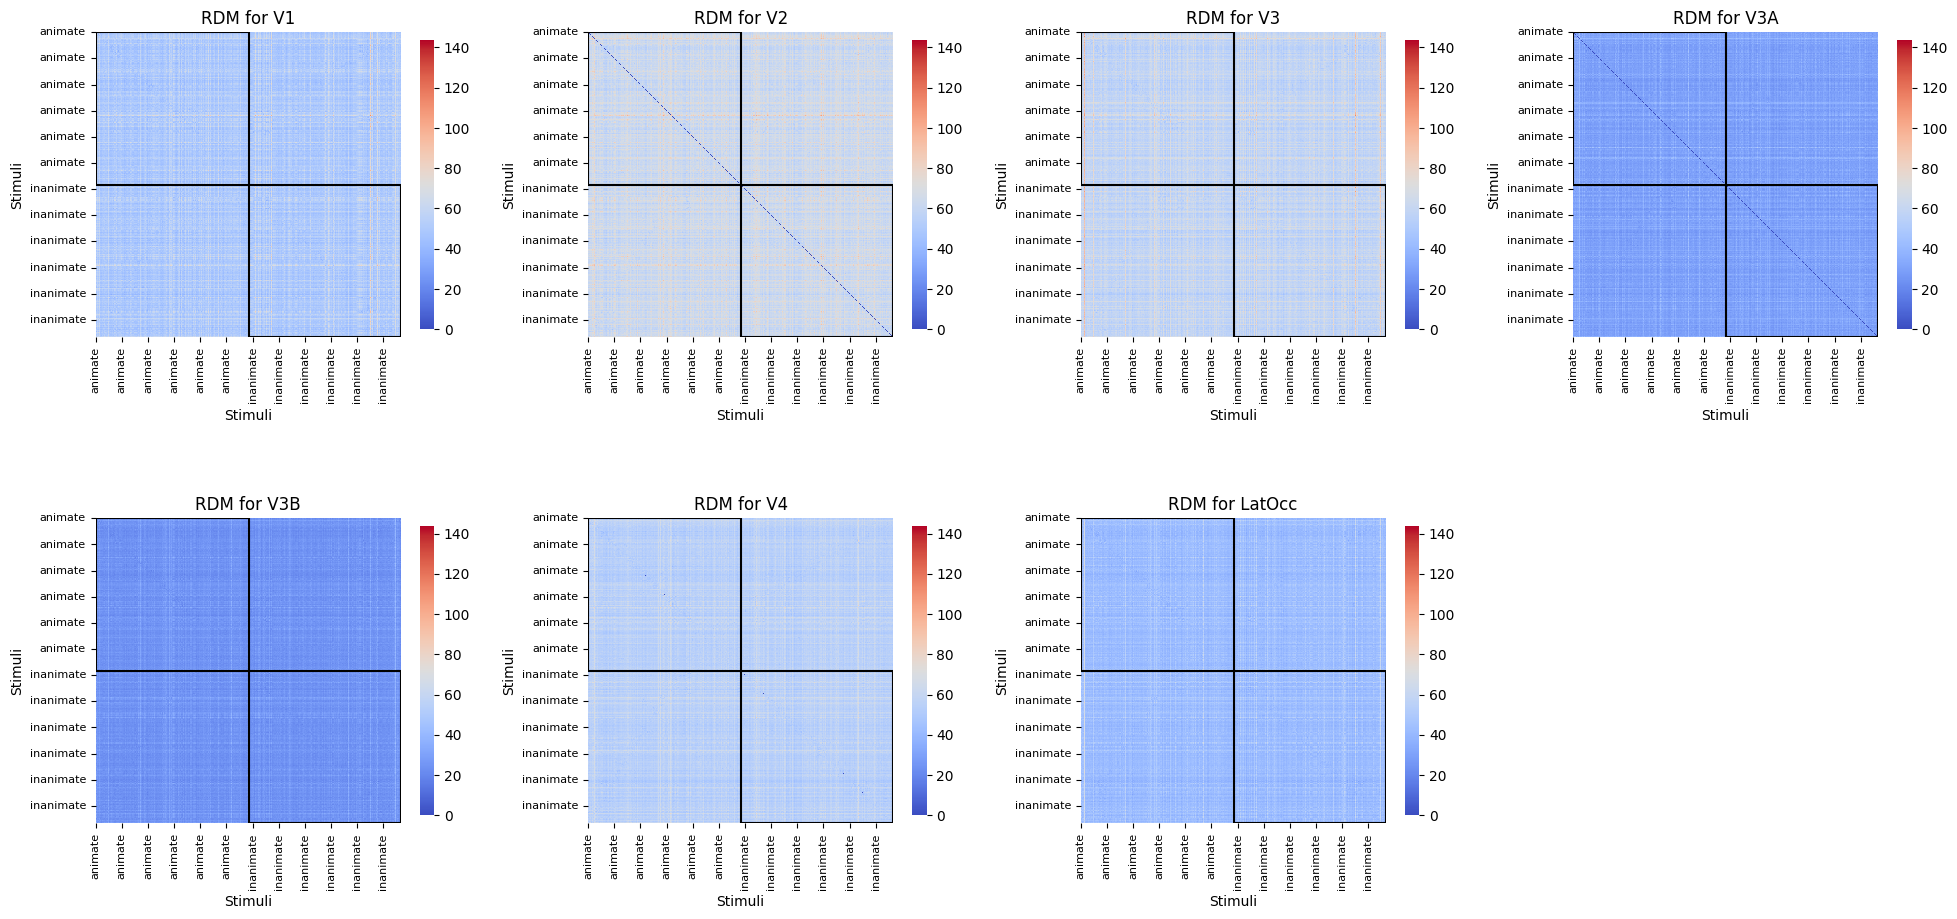

In [ ]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle


# Ensure the labels match the first n stimuli
n_stimuli = len(X_train)
X_train_n = X_train[:n_stimuli]
chatbot_labels_n = chatbot_labels[:n_stimuli]

# Create a mapping of labels to indices
label_order = np.argsort(chatbot_labels_n)
sorted_labels = np.array(chatbot_labels_n)[label_order]



# Compute RDM for each ROI with reordered stimuli
rdms = {}
for roi_name, responses_roi in roi_responses.items():
    # Reorder responses based on sorted labels
    responses_roi_100 = responses_roi[:n_stimuli][label_order]

    # Compute the RDM using Euclidean distance
    rdm = scipy.spatial.distance.pdist(responses_roi_100, metric='euclidean')
    rdm = scipy.spatial.distance.squareform(rdm)
    rdms[roi_name] = rdm

# Determine indices where the labels change
sorted_labels_c = np.array([0 if label == 'inanimate' else 1 for label in sorted_labels])
change_indices = np.where(np.diff(sorted_labels_c) != 0)[0] + 1
rdm_values = np.concatenate([rdm.flatten() for rdm in rdms.values()])
vmin = np.min(rdm_values)
vmax = np.max(rdm_values)

# --- Improved Plotting with Consistent Color Scale ---
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for ax, (roi_name, rdm) in zip(axes, rdms.items()):
    sns.heatmap(rdm, ax=ax, cmap='coolwarm', square=True, cbar_kws={'shrink': 0.7},
                vmin=vmin, vmax=vmax)  # Apply global vmin and vmax
    ax.set_title(f'RDM for {roi_name}', fontsize=12)
    ax.set_xlabel('Stimuli', fontsize=10)
    ax.set_ylabel('Stimuli', fontsize=10)

    ax.tick_params(axis='both', which='major', labelsize=8)

    for idx in change_indices:
        ax.add_patch(Rectangle((0, 0), idx, idx, fill=False, edgecolor='black', lw=1.5))
        ax.add_patch(Rectangle((idx, idx), len(sorted_labels) - idx, len(sorted_labels) - idx,
                                fill=False, edgecolor='black', lw=1.5))
    every_nth = 150
    xticks = np.arange(0, len(sorted_labels), every_nth)
    yticks = np.arange(0, len(sorted_labels), every_nth)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(sorted_labels[xticks])
    ax.set_yticklabels(sorted_labels[yticks])

for i in range(len(rdms), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout(pad=2)  # Add padding between subplots
plt.show()


In [ ]:
#Load Hmax responses from drive as csv
folder_path = '/content/drive/My Drive/Hmax_Dep/'
Hmax_C1=pd.read_csv(folder_path + 'dissimilarity_matrix.csv')


In [ ]:
Hmax_C1.columns=Hmax_C1.columns.astype(int)
Hmax_C1.index=Hmax_C1.index.astype(int)
Hmax_C1.shape


(1750, 1750)

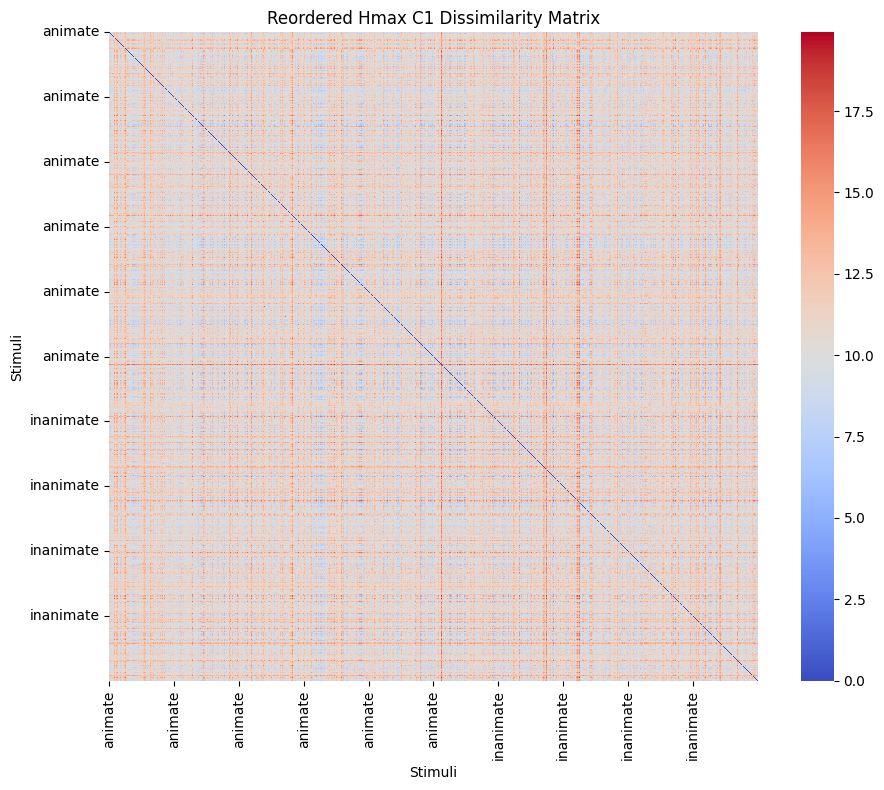

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Hmax_C1 is your original dissimilarity matrix as a pandas DataFrame
# and chatbot_labels contains your stimulus labels

# Ensure the labels match the first n stimuli
chatbot_labels_n = chatbot_labels[:n_stimuli]

# Create a mapping of labels to indices
label_order = np.argsort(chatbot_labels_n)
sorted_labels = np.array(chatbot_labels_n)[label_order]

# Reorder the dissimilarity matrix
Hmax_C1_reordered = Hmax_C1.iloc[label_order, label_order]

plt.figure(figsize=(10, 8))
sns.heatmap(Hmax_C1_reordered, cmap='coolwarm', square=True)
plt.title('Reordered Hmax C1 Dissimilarity Matrix')
plt.xlabel('Stimuli')
plt.ylabel('Stimuli')

# Add ticks and labels
every_nth = max(1, n_stimuli // 10)  # Show at most 10 ticks
ticks = np.arange(0, n_stimuli, every_nth)
plt.xticks(ticks, sorted_labels[ticks], rotation=90)
plt.yticks(ticks, sorted_labels[ticks])

plt.tight_layout()
plt.show()

In [ ]:
#First five columns and rows of Hmax_c1
Hmax_C1.iloc[:5, :5]

,0,1,2,3,4
0,0.000000,10.062614,9.772364,10.661768,10.481825
1,10.062614,0.000000,5.584097,9.201353,8.599331
2,9.772364,5.584097,0.000000,8.521284,9.194296
3,10.661768,9.201353,8.521284,0.000000,9.938898
4,10.481825,8.599331,9.194296,9.938898,0.000000


In [ ]:
Hmax_C1_reordered.iloc[:5, :5]

,0,1012,1009,1008,1007
0,0.000000,14.589306,8.698252,9.956247,11.313283
1012,14.589306,0.000000,13.575173,14.762972,12.007998
1009,8.698252,13.575173,0.000000,7.996056,9.056466
1008,9.956247,14.762972,7.996056,0.000000,8.819291
1007,11.313283,12.007998,9.056466,8.819291,0.000000


In [ ]:
sorted_labels

array(['animate', 'animate', 'animate', ..., 'inanimate', 'inanimate',
       'inanimate'], dtype='<U9')

In [ ]:
sorted_labels_c

array([1, 1, 1, ..., 0, 0, 0])

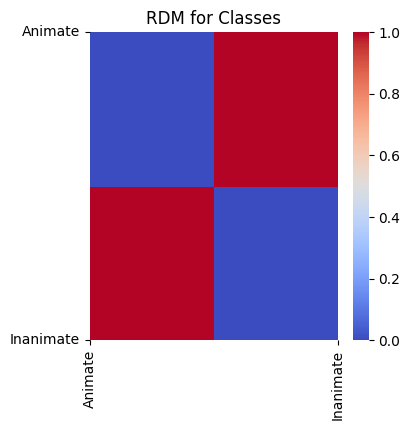

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance

# Assuming sorted_labels_c is already defined
class_rdm = scipy.spatial.distance.pdist(sorted_labels_c.reshape(-1, 1), metric='euclidean')
class_rdm = scipy.spatial.distance.squareform(class_rdm)

plt.figure(figsize=(4, 4))
sns.heatmap(class_rdm, cmap='coolwarm', cbar=True)
plt.title("RDM for Classes")

# Get the size of the matrix
matrix_size = class_rdm.shape[0]

tick_labels = ['Animate', 'Inanimate']
tick_positions = [0, matrix_size]

plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

plt.show()

In [ ]:

def kendall_tau_dissimilarity(matrix1, matrix2):
    """
    Calculates Kendall's Tau correlation between two dissimilarity matrices.

    Args:
        matrix1 (numpy.ndarray): First dissimilarity matrix.
        matrix2 (numpy.ndarray): Second dissimilarity matrix.

    Returns:
        float: Kendall's Tau correlation coefficient.
    """
    upper_triangular1 = np.triu(matrix1, 1)
    upper_triangular2 = np.triu(matrix2, 1)

    flattened1 = upper_triangular1[np.triu_indices(upper_triangular1.shape[0], 1)]
    flattened2 = upper_triangular2[np.triu_indices(upper_triangular2.shape[0], 1)]

    tau, p_value = kendalltau(flattened1, flattened2)

    return tau, p_value


In [ ]:
import plotly.graph_objects as go
from scipy.stats import kendalltau
from statsmodels.sandbox.stats.multicomp import multipletests

# Calculate Kendall's Tau and p-values
results = {}
for name, rdm in rdms.items():
    tau, p_value = kendall_tau_dissimilarity(rdm, class_rdm)
    results[name] = (tau, p_value)

# Extract p-values for multiple comparison correction
p_values = [results[name][1] for name in results]

# Multiple comparison correction using Benjamini-Hochberg
reject, p_values_corrected, _, _ = multipletests(
    p_values, method='bonferroni'
)

# Prepare data for plotting
rdm_names = list(results.keys())
taus = [results[name][0] for name in rdm_names]
p_values_corrected = list(p_values_corrected)

# Create bar plot with Plotly
fig = go.Figure()

# Plot Kendall's Tau
fig.add_trace(go.Bar(
    x=rdm_names,
    y=taus,
    name='Kendall\'s Tau',
    marker_color='blue'
))

# Plot corrected p-values
marker_colors = ['green' if p < 0.01 else 'orange' if p < 0.05 else 'red' for p in p_values_corrected]
fig.add_trace(go.Bar(
    x=rdm_names,
    y=p_values_corrected,
    name='P-value (FDR corrected)',
    marker_color=marker_colors
))

# Add significance annotations
for i, name in enumerate(rdm_names):
    x_pos = i
    if p_values_corrected[i] < 0.01:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="***",
            showarrow=False,
            font=dict(size=24),
            xref='x',
            yref='y',
            xanchor='center'
        )
    elif p_values_corrected[i] < 0.05:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="**",
            showarrow=False,
            font=dict(size=14),
            xref='x',
            yref='y',
            xanchor='center'
        )
    elif p_values_corrected[i] < 0.1:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="*",
            showarrow=False,
            font=dict(size=14),
            xref='x',
            yref='y',
            xanchor='center'
        )

fig.update_layout(
    title='Kendall\'s Tau and P-values (FDR corrected) for RDM comparisons between Categorical Inanimate-Animate model and ROI responses',
    xaxis_title='RDM',
    yaxis_title='Values',
    legend=dict(x=0.01, y=0.99),
    barmode='group'
)

fig.show()

In [ ]:
# Calculate Kendall's Tau and p-values
results = {}
for name, rdm in rdms.items():
    tau, p_value = kendall_tau_dissimilarity(rdm, Hmax_C1_reordered)
    results[name] = (tau, p_value)

# Extract p-values for multiple comparison correction
p_values = [results[name][1] for name in results]

# Multiple comparison correction using Benjamini-Hochberg
reject, p_values_corrected, _, _ = multipletests(
    p_values, method='bonferroni'
)

# Prepare data for plotting
rdm_names = list(results.keys())
taus = [results[name][0] for name in rdm_names]
p_values_corrected = list(p_values_corrected)

# Create bar plot with Plotly
fig = go.Figure()

# Plot Kendall's Tau
fig.add_trace(go.Bar(
    x=rdm_names,
    y=taus,
    name='Kendall\'s Tau',
    marker_color='blue'
))

# Plot corrected p-values
marker_colors = ['green' if p < 0.01 else 'orange' if p < 0.05 else 'red' for p in p_values_corrected]
fig.add_trace(go.Bar(
    x=rdm_names,
    y=p_values_corrected,
    name='P-value (FDR corrected)',
    marker_color=marker_colors
))

# Add significance annotations
for i, name in enumerate(rdm_names):
    x_pos = i
    if p_values_corrected[i] < 0.01:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="***",
            showarrow=False,
            font=dict(size=24),
            xref='x',
            yref='y',
            xanchor='center'
        )
    elif p_values_corrected[i] < 0.05:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="**",
            showarrow=False,
            font=dict(size=14),
            xref='x',
            yref='y',
            xanchor='center'
        )
    elif p_values_corrected[i] < 0.1:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="*",
            showarrow=False,
            font=dict(size=14),
            xref='x',
            yref='y',
            xanchor='center'
        )

fig.update_layout(
    title='Kendall\'s Tau and P-values (FDR corrected) for RDM comparisons between Hmax_C1 and ROI responses',
    xaxis_title='RDM',
    yaxis_title='Values',
    legend=dict(x=0.01, y=0.99),
    barmode='group'
)

fig.show()

In [ ]:
import os
# Specify the folder path in your Drive
folder_path = '/content/drive/My Drive/nmatch/'  # Replace with your actual folder path

os.makedirs(folder_path)
# Save each RDM as both .npy and .csv
for roi_name, rdm in rdms.items():

    # Save as .csv
    df = pd.DataFrame(rdm)
    df.to_csv(folder_path + f'rdm_{roi_name}.csv', index=False)

# Save animate/inanimate RDM
df_class_rdm = pd.DataFrame(class_rdm)
df_class_rdm.to_csv(folder_path + 'rdm_animate_inanimate.csv', index=False)

# Save reordered Hmax C1 RDM
df_hmax = pd.DataFrame(Hmax_C1_reordered)
df_hmax.to_csv(folder_path + 'rdm_hmax_reordered.csv', index=False)

print("All RDMs, animate/inanimate RDM, and Hmax reordered RDM saved successfully!")


All RDMs, animate/inanimate RDM, and Hmax reordered RDM saved successfully!


In [ ]:
# @title "Bootstrap Kendall's Tau (WIP not sure about the implementation will fix later if needed)"


import numpy as np
from scipy.stats import kendalltau

def bootstrap_kendall_tau(rdm1, rdm2, n_bootstraps=1000):
    """Performs bootstrapping to estimate the distribution of Kendall's Tau.

    Args:
        rdm1: First RDM (squareform or condensed).
        rdm2: Second RDM (squareform or condensed).
        n_bootstraps: Number of bootstrap samples to draw.

    Returns:
        tau_distribution: Array of Kendall's Tau values from bootstrapping.
    """

    n = len(rdm1)
    tau_distribution = []
    for _ in range(n_bootstraps):
        # Generate bootstrap indices (sampling with replacement)
        indices = np.random.choice(n, size=n, replace=True)

        # Calculate Kendall's Tau on the bootstrap sample
        tau, _ = kendalltau(rdm1[indices], rdm2[indices])
        tau_distribution.append(tau)
    return np.array(tau_distribution)
"""
# --- Bootstrapping and Visualization ---

n_bootstraps = 25  # Adjust as needed
bootstrap_results = {}

for name, rdm in rdms.items():
    tau_distribution = bootstrap_kendall_tau(rdm.flatten(), class_rdm.flatten(), n_bootstraps)
    bootstrap_results[name] = tau_distribution

# --- Plotting the Bootstrap Distributions ---

plt.figure(figsize=(12, 6))
for i, (name, tau_dist) in enumerate(bootstrap_results.items()):
    plt.subplot(2, 4, i+1)
    sns.histplot(tau_dist, kde=True)
    plt.title(f'{name} - Bootstrap Tau')
    plt.xlabel("Kendall's Tau")
    plt.tight_layout()
plt.show()

# --- Calculate p-values from bootstrap distributions ---
bootstrap_p_values = {}
for name, tau_dist in bootstrap_results.items():
    observed_tau = results[name][0]  # Get original observed Tau
    p_value = np.sum(tau_dist >= observed_tau) / n_bootstraps  # One-sided p-value
    bootstrap_p_values[name] = p_value

print("Bootstrap p-values:", bootstrap_p_values)
"""

'\n# --- Bootstrapping and Visualization ---\n\nn_bootstraps = 25  # Adjust as needed\nbootstrap_results = {}\n\nfor name, rdm in rdms.items():\n    tau_distribution = bootstrap_kendall_tau(rdm.flatten(), class_rdm.flatten(), n_bootstraps)\n    bootstrap_results[name] = tau_distribution\n\n# --- Plotting the Bootstrap Distributions ---\n\nplt.figure(figsize=(12, 6))\nfor i, (name, tau_dist) in enumerate(bootstrap_results.items()):\n    plt.subplot(2, 4, i+1)\n    sns.histplot(tau_dist, kde=True)\n    plt.title(f\'{name} - Bootstrap Tau\')\n    plt.xlabel("Kendall\'s Tau")\n    plt.tight_layout()\nplt.show()\n\n# --- Calculate p-values from bootstrap distributions ---\nbootstrap_p_values = {}\nfor name, tau_dist in bootstrap_results.items():\n    observed_tau = results[name][0]  # Get original observed Tau\n    p_value = np.sum(tau_dist >= observed_tau) / n_bootstraps  # One-sided p-value\n    bootstrap_p_values[name] = p_value\n\nprint("Bootstrap p-values:", bootstrap_p_values)\n'